# Data Cleansing in Google Cloud's Big Query

## SQL Queries

In [ ]:
CREATE VIEW `acms80695-384817.Option_Metrics.09_Options_Complete` AS
SELECT
t1.*,
t2.best_bid, t2.best_offer, t2.am_settlement
FROM `acms80695-384817.Option_Metrics.03_Option_Info` AS t1
JOIN `acms80695-384817.Option_Metrics.04_Option_Prices` AS t2
ON t1.optionid = t2.optionid AND t1.date = t2.date

In [ ]:
CREATE TABLE `acms80695-384817.Option_Metrics.10_sec_zero` AS
SELECT t1.secid, t1.`date`, t1.ticker, t1.industry_group, t1.close AS under_price, 
       AVG(t1.return) AS return,
       COALESCE(AVG(t2.rate), 0) AS zero_coupon
FROM `acms80695-384817.Option_Metrics.08_Security_Prices` AS t1
LEFT JOIN `acms80695-384817.Option_Metrics.02_Zero_Coupon_Yield_Curve` AS t2
    ON t1.`date` = t2.`date`
WHERE t1.index_flag = 1
GROUP BY t1.`date`, t1.secid, t1.ticker, t1.industry_group, t1.close

In [ ]:
CREATE VIEW `acms80695-384817.Option_Metrics.11_sec_ze_in` AS
SELECT
t1.*,
t2.rate AS div_yield
FROM `Option_Metrics.10_sec_zero` as t1
LEFT JOIN `Option_Metrics.01_Index_Dividend_Yield` as t2
ON t1.secid = t2.secid AND t1.date = t2.date

In [ ]:
CREATE VIEW `acms80695-384817.Option_Metrics.12_opt_filt`
SELECT
secid, `date`, exdate, cp_flag, strike_price, impl_volatility, best_bid, best_offer
FROM `acms80695-384817.Option_Metrics.09_Options_Complete`
WHERE index_flag = 1 AND exercise_style = 'E' AND div_convention = 'I'
      AND  am_settlement = 0

In [ ]:
CREATE TABLE `acms80695-384817.Option_Metrics.13_complete_v1` AS
SELECT 
  t1.secid, 
  t1.date, 
  t1.strike_price,
  t1.cp_flag,
  MAX(t1.exdate) AS exdate,
  MAX(t1.impl_volatility) AS impl_volatility,
  MAX(t1.best_bid) AS best_bid,
  MAX(t1.best_offer) AS best_offer,
  MAX(t2.under_price) AS under_price,
  MAX(t2.zero_coupon) AS zero_coupon,
  MAX(t2.div_yield) AS div_yield
FROM 
  `acms80695-384817.Option_Metrics.12_opt_filt` AS t1
LEFT JOIN 
  `acms80695-384817.Option_Metrics.11_sec_ze_in` AS t2
ON 
  t1.secid = t2.secid AND t1.date = t2.date
GROUP BY 
  t1.secid, t1.date, t1.strike_price, t1.cp_flag

In [ ]:
CREATE TABLE `acms80695-384817.Option_Metrics.14_complete_v1` AS
SELECT
  secid, `date`, strike_price, impl_volatility, under_price, zero_coupon, div_yield,
  (best_bid + best_offer)/2 AS midpoint,
  CASE
    WHEN cp_flag = 'C' THEN 1
    ELSE 0
  END AS opt_type,
  DATE_DIFF(TIMESTAMP(exdate), TIMESTAMP(`date`), DAY)/365.25 AS time
FROM
  `acms80695-384817.Option_Metrics.13_complete_v1`

In [ ]:
CREATE TABLE `acms80695-384817.Option_Metrics.15_prices` AS
SELECT
secid, `date`, under_price
FROM `acms80695-384817.Option_Metrics.11_sec_ze_in`
ORDER BY secid, `date`

In [ ]:
CREATE TABLE `acms80695-384817.Option_Metrics.16_lags` AS
SELECT
  secid, `date`, under_price,
  LAG(under_price, 1) OVER (PARTITION BY secid ORDER BY date) AS under_lag1,
  LAG(under_price, 2) OVER (PARTITION BY secid ORDER BY date) AS under_lag2,
  LAG(under_price, 3) OVER (PARTITION BY secid ORDER BY date) AS under_lag3,
  LAG(under_price, 4) OVER (PARTITION BY secid ORDER BY date) AS under_lag4,
  LAG(under_price, 5) OVER (PARTITION BY secid ORDER BY date) AS under_lag5,
  LAG(under_price, 6) OVER (PARTITION BY secid ORDER BY date) AS under_lag6,
  LAG(under_price, 7) OVER (PARTITION BY secid ORDER BY date) AS under_lag7,
  LAG(under_price, 8) OVER (PARTITION BY secid ORDER BY date) AS under_lag8,
  LAG(under_price, 9) OVER (PARTITION BY secid ORDER BY date) AS under_lag9,
  LAG(under_price, 10) OVER (PARTITION BY secid ORDER BY date) AS under_lag10,
  LAG(under_price, 11) OVER (PARTITION BY secid ORDER BY date) AS under_lag11,
  LAG(under_price, 12) OVER (PARTITION BY secid ORDER BY date) AS under_lag12,
  LAG(under_price, 13) OVER (PARTITION BY secid ORDER BY date) AS under_lag13,
  LAG(under_price, 14) OVER (PARTITION BY secid ORDER BY date) AS under_lag14,
  LAG(under_price, 15) OVER (PARTITION BY secid ORDER BY date) AS under_lag15,
  LAG(under_price, 16) OVER (PARTITION BY secid ORDER BY date) AS under_lag16,
  LAG(under_price, 17) OVER (PARTITION BY secid ORDER BY date) AS under_lag17,
  LAG(under_price, 18) OVER (PARTITION BY secid ORDER BY date) AS under_lag18,
  LAG(under_price, 19) OVER (PARTITION BY secid ORDER BY date) AS under_lag19,
  LAG(under_price, 20) OVER (PARTITION BY secid ORDER BY date) AS under_lag20
FROM `Option_Metrics.15_prices`

In [ ]:
CREATE TABLE `acms80695-384817.Option_Metrics.17_joined` AS
SELECT
t1.*,
t2.* EXCEPT(secid, date, under_price)
FROM `Option_Metrics.14_complete_v1` as t1
LEFT JOIN `Option_Metrics.16_lags` as t2
ON t1.date = t2.date AND t1.secid = t2.secid AND t1.under_price = t2.under_price

In [ ]:
CREATE TABLE `acms80695-384817.Option_Metrics.18_download` AS
SELECT
secid, `date`, strike_price/1000 AS strike_price,
* EXCEPT(secid, `date`, strike_price)
FROM `acms80695-384817.Option_Metrics.17_joined`
WHERE
  secid IS NOT NULL AND
  `date` IS NOT NULL AND
  strike_price IS NOT NULL AND
  impl_volatility IS NOT NULL AND
  under_price IS NOT NULL AND
  zero_coupon IS NOT NULL AND
  div_yield IS NOT NULL AND
  midpoint IS NOT NULL AND
  opt_type IS NOT NULL AND
  `time` IS NOT NULL AND
  under_lag1 IS NOT NULL AND
  under_lag2 IS NOT NULL AND
  under_lag3 IS NOT NULL AND
  under_lag4 IS NOT NULL AND
  under_lag5 IS NOT NULL AND
  under_lag6 IS NOT NULL AND
  under_lag7 IS NOT NULL AND
  under_lag8 IS NOT NULL AND
  under_lag9 IS NOT NULL AND
  under_lag10 IS NOT NULL AND
  under_lag11 IS NOT NULL AND
  under_lag12 IS NOT NULL AND
  under_lag13 IS NOT NULL AND
  under_lag14 IS NOT NULL AND
  under_lag15 IS NOT NULL AND
  under_lag16 IS NOT NULL AND
  under_lag17 IS NOT NULL AND
  under_lag18 IS NOT NULL AND
  under_lag19 IS NOT NULL AND
  under_lag20 IS NOT NULL AND
  under_price > 0 AND
  under_price < 1000000

## Big Query Interface

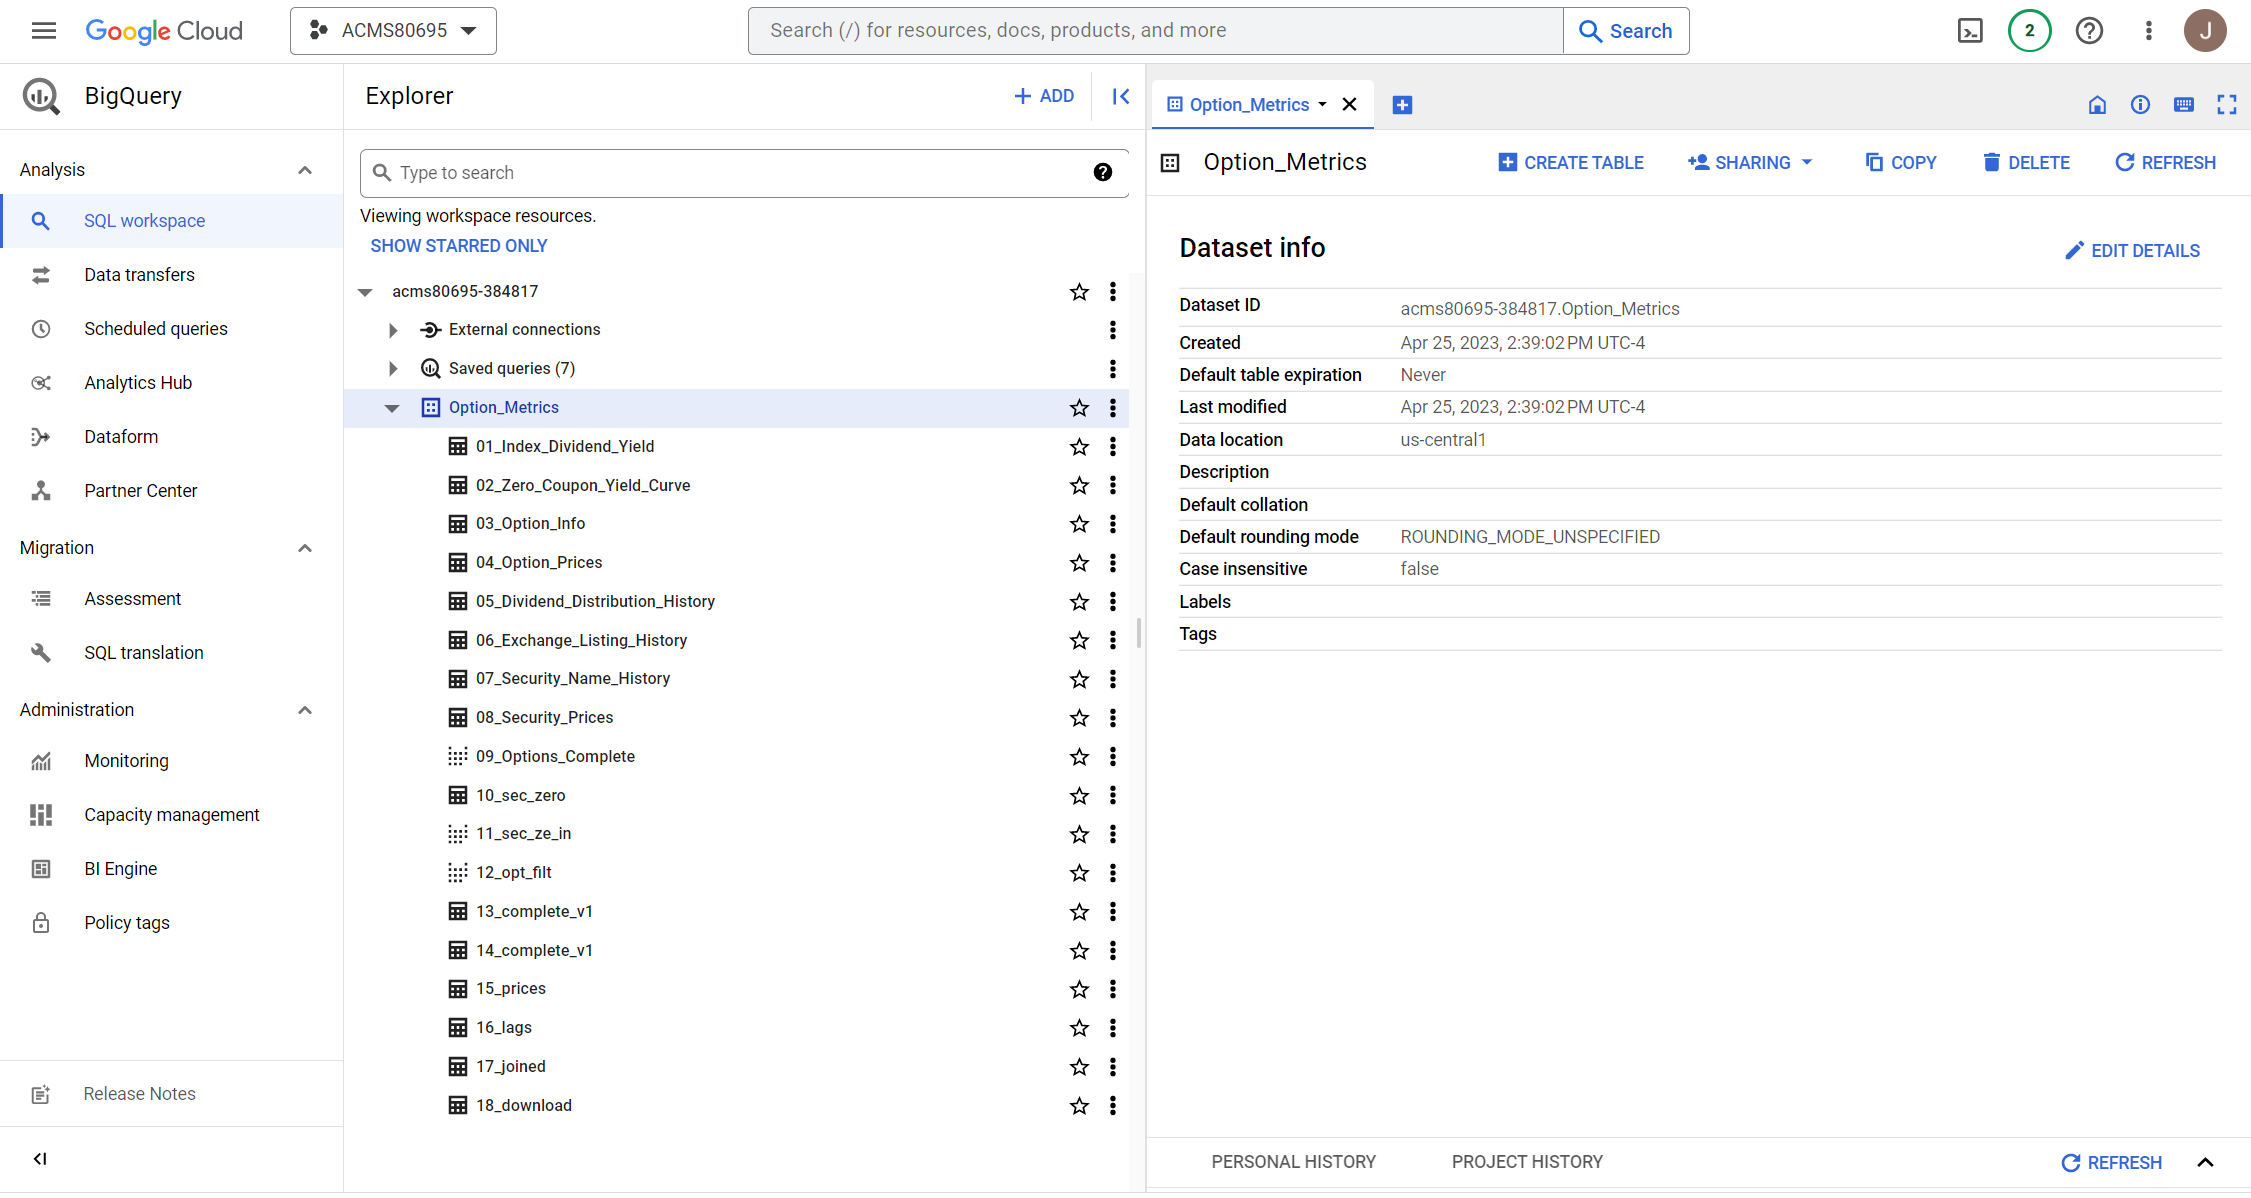

## Datasets Used

The data for this project was collected from the _IvyDB US Dataset by Option Metrics_ which can be found at https://wrds-www.wharton.upenn.edu/pages/about/data-vendors/optionmetrics/ with a Wharton Research Data Services account. The University of Notre Dame's Hesburgh Library can provide students and faculty access to this data as of the time of this writing. Summaries of the data downloaded can be found below.

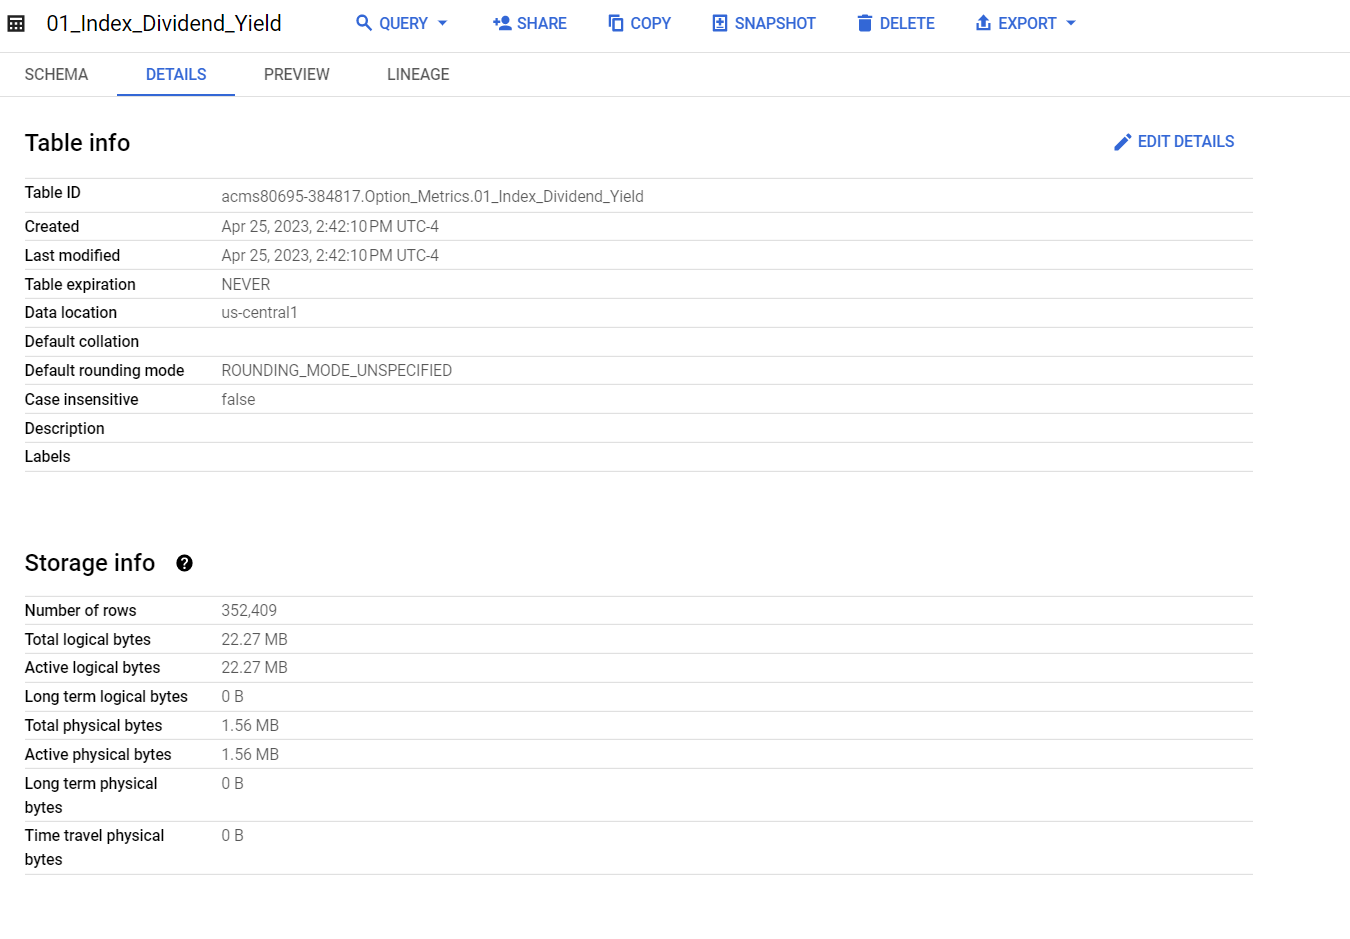  

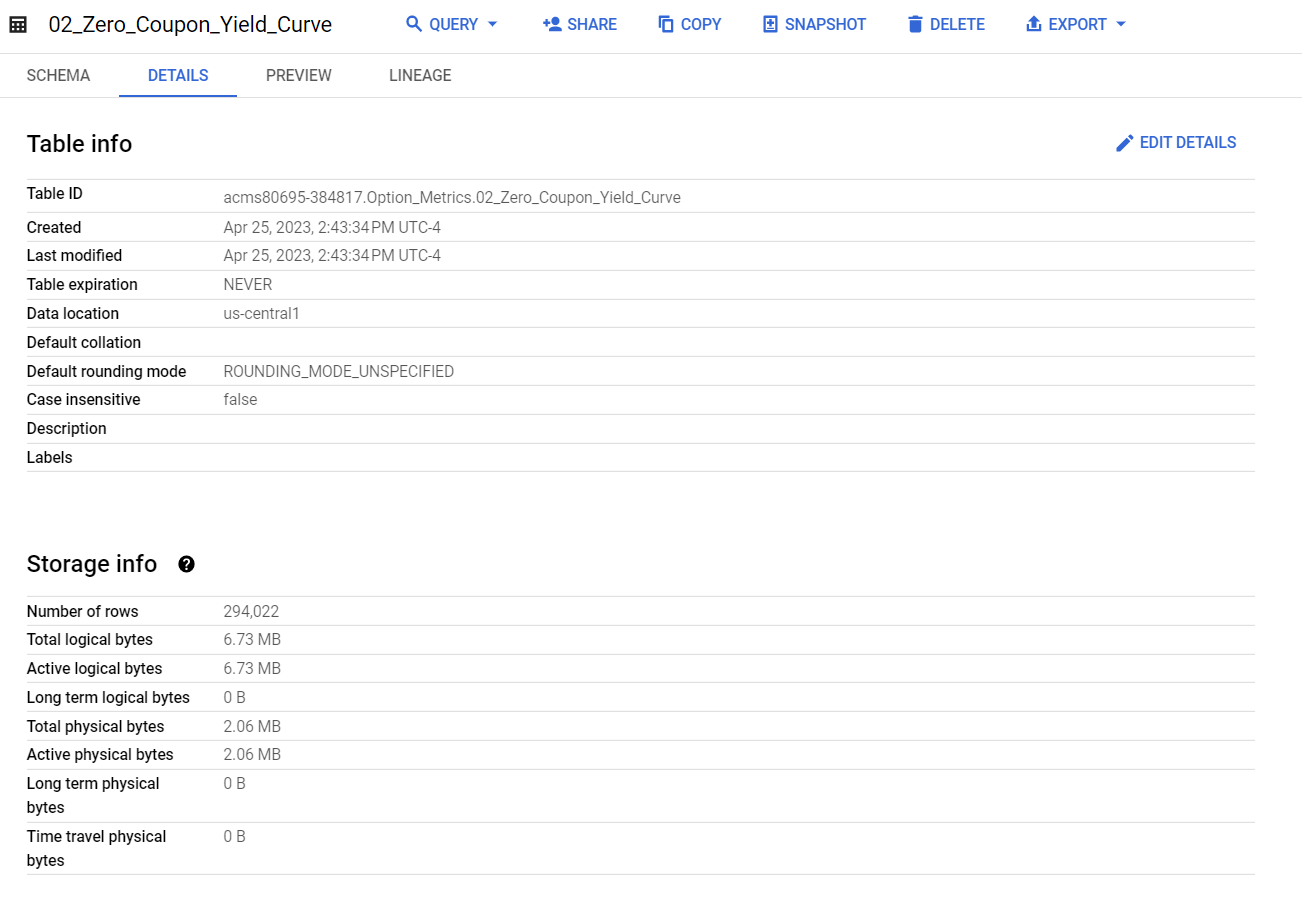  

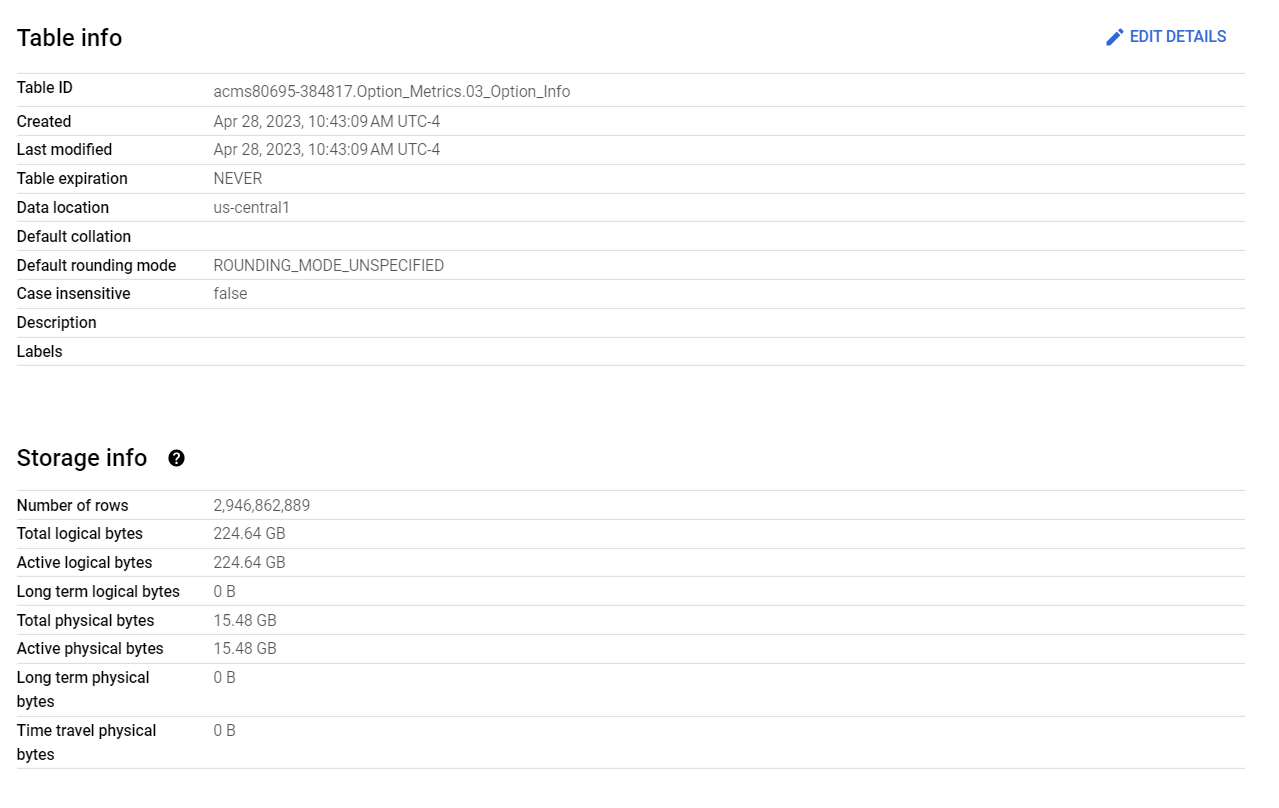  

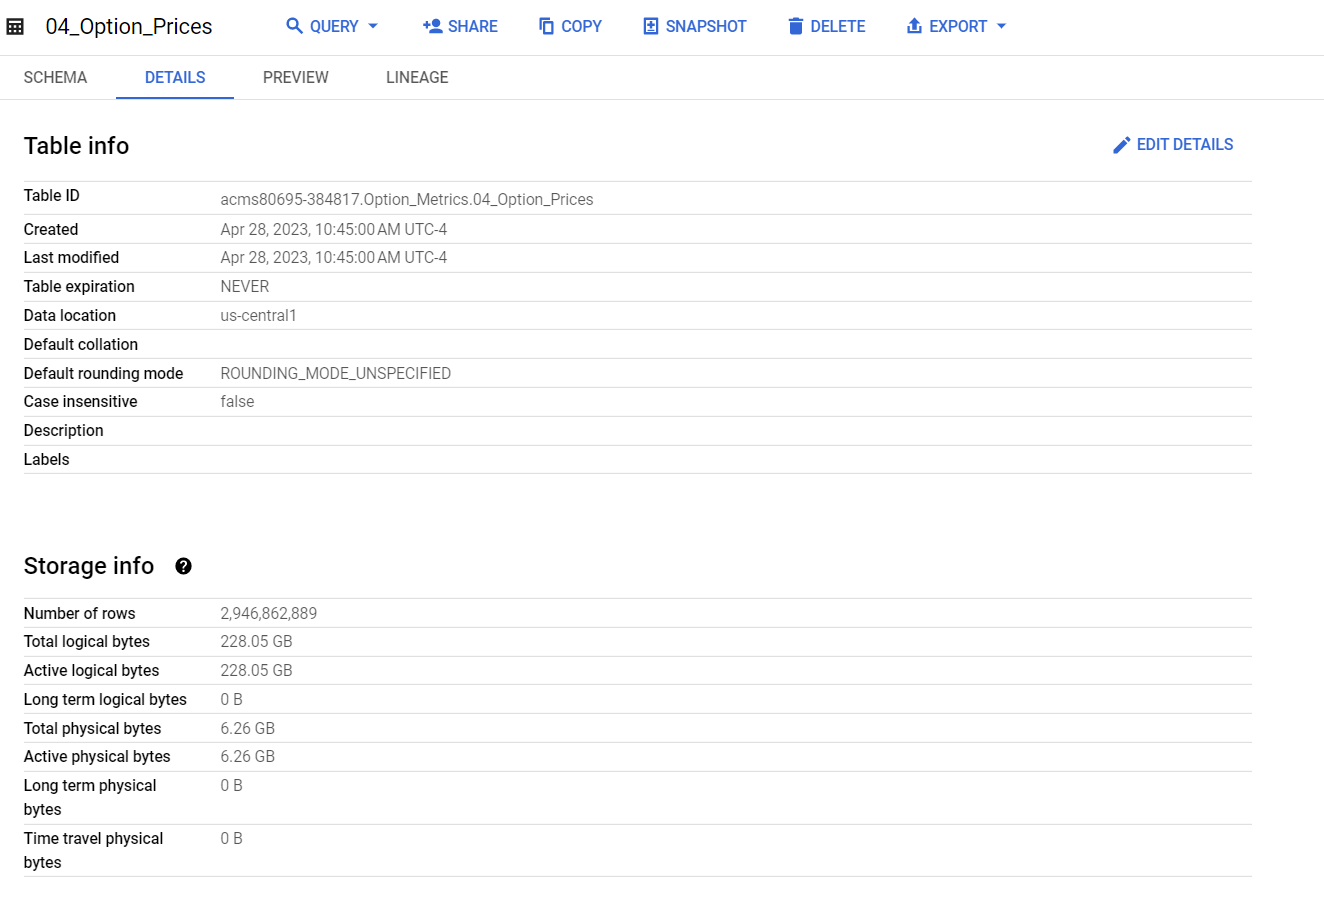  

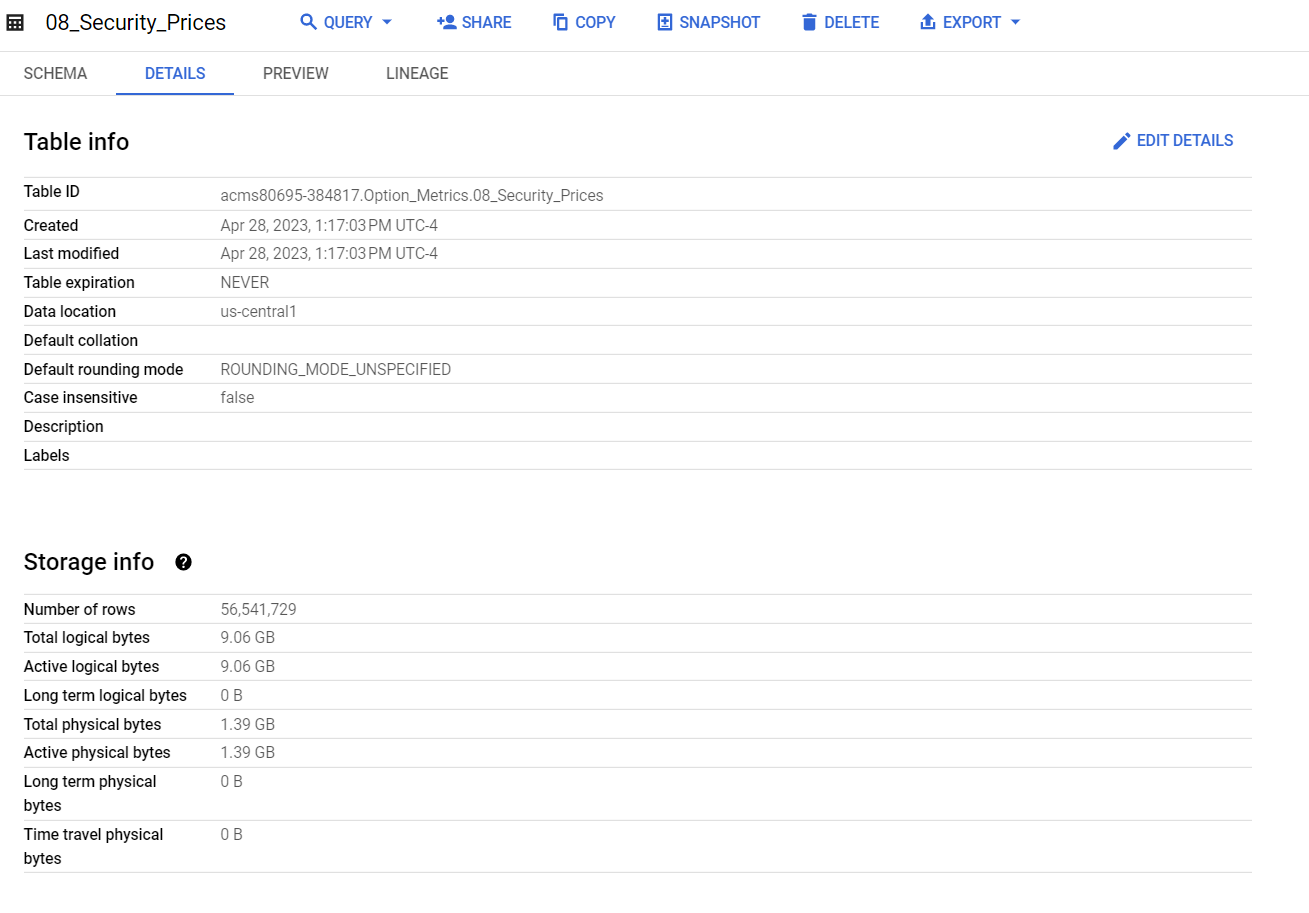